# Mouvements de joystick analyses : Version 4

In [15]:
# File manipulation
import os
from os.path import exists

# General
import numpy as np
import pandas as pd
import time
from collections import Counter

# Signal processing
from scipy.io import wavfile
from scipy.interpolate import interp1d
from scipy import signal
from scipy import stats
from scipy.signal import periodogram
from scipy.signal import find_peaks

# MFCC
import librosa, librosa.display

# Wavelets
import pywt
from pywt import wavedec

# Visualization
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

# Image processing
from PIL import Image

# Scaling signal
from mlxtend.preprocessing import minmax_scaling

# Loading and saving data
import pickle

PCtype = 'Linux'

varr = {}
if PCtype == 'Windows':
    # Windows
    # varr['main_path'] = "C:\\Users\\jamilah\\Documents\\Github_analysis_PROJECTS\\Time_series_analysis\\Motor_classification\\Motor_classification"  
    # varr['main_path1'] = "%s\\a_data_standardization" % (varr['main_path'])
    # varr['main_path2'] = "%s\\b_data_preprocessing" % (varr['main_path'])
    # varr['main_path3'] = "%s\\c_calculate_metrics" % (varr['main_path'])
    filemarker = '\\'
elif PCtype == 'Linux':
    # Linux
    # varr['main_path'] = "/home/oem2/Documents/PROGRAMMING/9_Motor_classification_2018-22/Coding_version3_python_FINAL"
    # varr['main_path'] = "/home/oem2/Documents/GITarea/Motor_classification"
    # varr['main_path1'] = "%s/a_data_standardization" % (varr['main_path'])
    # varr['main_path2'] = "%s/b_data_preprocessing" % (varr['main_path'])
    # varr['main_path3'] = "%s/c_calculate_metrics" % (varr['main_path'])
    filemarker = '/'


# Fonctions utilitaires

In [16]:
def put_timeseries_trialdata_into_pandas(varr, filemarker):
    
    df_timeseries_exp = {}

    # 1) Load exp : put the experiment that you wish to run
    for exp in range(2):  # 0=rotation, 1=translation
        # print('exp : ', exp)

        if exp == 0:
            # Rotational data - 18 participants
            varr['which_exp'] = 'rot'
            varr['anom'] = 'RO', 'PI', 'YA'
            
            # Time series data per subject per trial
            file_name1 = "%s%srotdat.pkl" % (varr['main_path2'], filemarker)

            # Load data experimental preprocessed data matrix
            file_name2 = "%s%srot_Xexp.pkl" % (varr['main_path3'], filemarker)
        elif exp == 1:
            # Translational data - 14 participants
            varr['which_exp'] = 'trans'
            varr['anom'] = 'LR', 'FB', 'UD'

            # Time series data per subject per trial
            file_name1 = "%s%stransdat.pkl" % (varr['main_path2'], filemarker)

            # Experimental preprocessed : a scalar metric per subject per trial
            file_name2 = "%s%strans_Xexp.pkl" % (varr['main_path3'], filemarker)

        open_file = open(file_name1, "rb")
        dat = pickle.load(open_file)
        open_file.close()

        open_file = open(file_name2, "rb")
        X = pickle.load(open_file)
        open_file.close()
        
        num_of_subs = len(X)    # OR dat.shape[0]

        Xsub = []
        
        for s in range(num_of_subs):
            # print('s : ', s)
            
            num_of_tr = len(dat[s][0])  # OR X[0].shape[0]

            for tr in range(num_of_tr):
                # print('tr : ', tr)
                
                # time series dataFrame (ensure vectors are a column): 
                num_dp = len(dat[s][4][tr][:,0])

                subject = s*np.ones((num_dp,1))
                trial = tr*np.ones((num_dp,1))
                ss = dat[s][0][tr]*np.ones((num_dp,1))
                ax = dat[s][1][tr]*np.ones((num_dp,1))

                dp = np.reshape(list(range(num_dp)), (num_dp,1))
                time = np.reshape(dat[s][8][tr], (num_dp,1))

                res_type = X[s][:,5][tr]*np.ones((num_dp,1))
                
                outSIGCOM_ax0 = np.reshape(dat[s][4][tr][:,0], (num_dp,1))
                outSIGCOM_ax1 = np.reshape(dat[s][4][tr][:,1], (num_dp,1))
                outSIGCOM_ax2 = np.reshape(dat[s][4][tr][:,2], (num_dp,1))

                outSIG_ax0 = np.reshape(dat[s][5][tr][:,0], (num_dp,1))
                outSIG_ax1 = np.reshape(dat[s][5][tr][:,1], (num_dp,1))
                outSIG_ax2 = np.reshape(dat[s][5][tr][:,2], (num_dp,1))

                outJOY_ax0 = np.reshape(dat[s][6][tr][:,0], (num_dp,1))
                outJOY_ax1 = np.reshape(dat[s][6][tr][:,1], (num_dp,1))
                outJOY_ax2 = np.reshape(dat[s][6][tr][:,2], (num_dp,1))

                outNOISE_ax0 = np.reshape(dat[s][7][tr][:,0], (num_dp,1))
                outNOISE_ax1 = np.reshape(dat[s][7][tr][:,1], (num_dp,1))
                outNOISE_ax2 = np.reshape(dat[s][7][tr][:,2], (num_dp,1))
                
                X_row = np.ravel(subject), np.ravel(trial), np.ravel(ss), np.ravel(ax), np.ravel(dp), np.ravel(time), np.ravel(res_type), np.ravel(outSIGCOM_ax0), np.ravel(outSIGCOM_ax1), np.ravel(outSIGCOM_ax2), np.ravel(outSIG_ax0), np.ravel(outSIG_ax1), np.ravel(outSIG_ax2), np.ravel(outJOY_ax0), np.ravel(outJOY_ax1), np.ravel(outJOY_ax2), np.ravel(outNOISE_ax0), np.ravel(outNOISE_ax1), np.ravel(outNOISE_ax2),
                Xtr = np.transpose(X_row)
                # print('shape of Xtr : ', Xtr.shape)
                
                # concatenate accumulated matrix with new
                if s == 0 and tr == 0:
                    Xsub = Xtr
                else:
                    Xsub = np.concatenate((Xsub, Xtr), axis=0)
                
                # print('len of Xsub : ', len(Xsub))
                
        
        columns = ['subject', 'tr', 'ss', 'ax', 'dp', 'time', 'res_type', 'SIGCOM_ax0', 'SIGCOM_ax1', 'SIGCOM_ax2', 'SIG_ax0', 'SIG_ax1', 'SIG_ax2', 'JOY_ax0', 'JOY_ax1', 'JOY_ax2', 'NOISE_ax0', 'NOISE_ax1', 'NOISE_ax2']
        out1 = np.reshape(Xsub, (len(Xsub), len(columns)))
        
        df = pd.DataFrame(out1, columns=columns)

        df_timeseries_exp[varr['which_exp']] = df

    return df_timeseries_exp

In [17]:
# np.nan can not process strings,  use this.
def isnan(value):
    try:
        return math.isnan(float(value))
    except:
        return False

In [18]:
def my_dropna_python(df):
    # Python
    col_names = list(df.columns.values)
    # OR
    # col_names = list(df.columns)
    
    df = df.to_numpy()
    df = np.array(df)
    # print('size of df : ', df.shape)
    data = []
    num_of_cols = df.shape[1]
    for i in range(df.shape[0]):
        row_vec = df[i,:]
        
        out = [isnan(row_vec[i]) for i in range(len(row_vec))]
        # OR
        # out = []
        # for i in range(len(row_vec)):
            # #print('row_vec[i]', row_vec[i])
            # out.append(isnan(row_vec[i]))
        
        out = make_a_properlist(out)  # for dataframes with nested arrays
        
        if any(out) == False:
            data.append(df[i,:])
    
    num_of_rows = len(data)
    data0 = np.reshape(data, (num_of_rows, num_of_cols))
    
    df_new = pd.DataFrame(data=data0, columns=col_names)
    
    return df_new

In [19]:
def make_a_properlist(vec):
    
    out = []
    for i in range(len(vec)):
        out = out + [np.ravel(vec[i])]
        
    if is_empty(out) == False:
        vecout = np.concatenate(out).ravel().tolist()
    else:
        vecout = list(np.ravel(out))
    
    return vecout

def is_empty(vec):
    vec = np.array(vec)
    if vec.shape[0] == 0:
        out = True
    else:
        out = False
        
    return out

In [20]:
def numderiv(x, t):
    # Created by Jamilah Foucher, Février 01, 2021

    # Purpose: Numerical derivative
    # 
    # Input VARIABLES:
    # (1) x is a vector in which you want the numerical derivative
    # 
    # (2) t is a time vector

    # Output VARIABLES:
    # (1) dx is a vector of the numerical derivative

    # -------------------------------

    if len(x) > 4:
        dx0 = np.ones(len(x))
        for i in range(len(x)-1):
            dx0[i] = ( x[i+1] - x[i] ) / ( t[i+1] - t[i] )
        dx = dx0[0:len(dx0)-2], dx0[len(dx0)-2], dx0[len(dx0)-2] 
    dx = make_a_properlist(dx)
       
    return dx

In [21]:
def sort_dict_by_value(d, reverse = False):
    return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

In [22]:
def interpretation_of_kstest(statistic, pvalue):
     # or np.isclose(pvalue, 1, atol=0.1)
    if np.isclose(statistic, 0, atol=0.01):    # default atol=1e-08
        out = 1 # result is parametric/normal
    else:
        out = 0  # result is non-parametric/non-normal

    return out

In [23]:
def normal_distribution_feature_data(feat, plotORnot):
    # Make distribution of feature parametric per trial
    
    # Check for constant vectors
    baseline_f = feat - feat[0]
    if int(np.mean(baseline_f)) == 0:
        return feat
    else:
        # Check if the feature has a normal distribution

        statistic, pvalue = stats.kstest(feat, 'norm')
        # print('statistic : ', statistic, ', pvalue : ', pvalue)
        result = interpretation_of_kstest(statistic, pvalue)
        # print('result : ', result)

        # Initialize : use feature if it has normal distribution OR if normal distribution can not be found
        norm_feat = feat

        if result == 0 and np.isnan(feat).any() == False:
            # Does not work for negative values, so shift up a little bit above zero
            pos_shift = feat - (np.min(feat)-0.000001)
            # print('min val : ', np.min(pos_shift))

            # ----------------

            normaldist0 = stats.boxcox(pos_shift)
            # ----------------
            # OR
            # ----------------
            # Stack two signals because the functions can not process a single signal alone
            X = pos_shift, pos_shift
            X = np.transpose(X)
            # print('shape of X : ', X.shape)
            # ----------------

            # https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html

            # ----------------
            bc = PowerTransformer(method='box-cox')
            normaldist1 = bc.fit(X).transform(X)
            # ----------------

            # ----------------
            yj = PowerTransformer(method='yeo-johnson')
            normaldist2 = yj.fit(X).transform(X)
            # ----------------

            # ----------------

            rng = np.random.RandomState(0)
            num_of_samps = len(feat)
            qt = QuantileTransformer(n_quantiles=num_of_samps, output_distribution='normal', random_state=rng)
            normaldist3 = qt.fit(X).transform(X)
            # ----------------

            # Some of the distribution transformations do not always work.  Test to see if the test suceeded.
            statistic, pvalue = stats.kstest(normaldist0[0], 'norm')
            result0 = interpretation_of_kstest(statistic, pvalue)

            statistic, pvalue = stats.kstest(normaldist1[:,0], 'norm')
            result1 = interpretation_of_kstest(statistic, pvalue)

            statistic, pvalue = stats.kstest(normaldist2[:,0], 'norm')
            result2 = interpretation_of_kstest(statistic, pvalue)

            statistic, pvalue = stats.kstest(normaldist3[:,0], 'norm')
            result3 = interpretation_of_kstest(statistic, pvalue)

            allres = [result0, result1, result2, result3]
            # print('allres : ', allres)

            all_dat = normaldist0[0], list(normaldist1[:,0]), list(normaldist2[:,0]), list(normaldist3[:,0])
            all_dat = np.transpose(all_dat)

            for i in range(len(allres)):
                if allres[i] == 1:
                    norm_feat = all_dat[:,i]
                    break

            # if plotORnot == 1:
                # # histogram
                # print('shape of all_dat : ', all_dat.shape)
                # dfout = pd.DataFrame(data=all_dat)


                # fig, ax=plt.subplots(4,1)
                # sns.distplot(dfout[0], ax=ax[0], bins=30, label="stats") 
                # sns.distplot(dfout[1], ax=ax[1], bins=30, label='bc')
                # sns.distplot(dfout[2], ax=ax[2], bins=30, label='yj')
                # sns.distplot(dfout[3], ax=ax[3], bins=30, label='qt')

        return norm_feat

In [24]:
def linear_intercurrentpt_makeshortSIGlong_interp1d(shortSIG, longSIG):

    x = np.linspace(shortSIG[0], len(shortSIG), num=len(shortSIG), endpoint=True)
    y = shortSIG
    # print('x : ', x)


    # -------------
    kind = 'linear'
    # kind : Specifies the kind of interpolation as a string or as an integer specifying 
    # the order of the spline interpolator to use. The string has to be one of ‘linear’, ‘nearest’, 
    # ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’. ‘zero’, ‘slinear’, 
    # ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; 
    # ‘previous’ and ‘next’ simply return the previous or next value of the point; ‘nearest-up’ and 
    # ‘nearest’ differ when interpolating half-integers (e.g. 0.5, 1.5) in that ‘nearest-up’ rounds 
    # up and ‘nearest’ rounds down. Default is ‘linear’.

    if kind == 'linear':
        f = interp1d(x, y)
    elif kind == 'cubic':
        f = interp1d(x, y, kind='cubic')
    # -------------

    xnew = np.linspace(shortSIG[0], len(shortSIG), num=len(longSIG), endpoint=True)
    # print('xnew : ', xnew)

    siglong = f(xnew)

    return siglong

In [25]:
# level : the number of levels to decompose the time signal, le nombre des marquers par signale
def tsig_2_discrete_wavelet_transform(sig, waveletname, level, plotORnot):

    # On peut calculater dans deux façons: 0) dwt en boucle and then idwt, 1) wavedec et waverec
    # Mais le deux ne donnent pas le meme reponses, wavedec et waverec semble plus raisonable.
    coeff = wavedec(sig, waveletname, level)

    if plotORnot == 1:
        fig, axx = plt.subplots(nrows=len(coeff), ncols=1, figsize=(5,5))
        axx[0].set_title("coef")  # Pas certain si c'est coef0 ou coef1
        for k in range(len(coeff)):
            axx[k].plot(coeff[k], 'r') # output of the low pass filter (averaging filter) of the DWT
        plt.tight_layout()
        plt.show()

    return coeff

In [26]:
def tsig_2_spectrogram(sig, fs, nfft, noverlap, img_dim, plotORnot):

    # -----------------------------------
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    # spectrum2D array : Columns are the periodograms of successive segments.
    # freqs1-D array : The frequencies corresponding to the rows in spectrum.
    # t1-D array : The times corresponding to midpoints of segments (i.e., the columns in spectrum).
    # imAxesImage : The image created by imshow containing the spectrogram.
    pxx, freqs, bins, img = ax.specgram(sig, nfft, fs, noverlap=noverlap)
    ax.axis('off')

    # -----------------------------------

    my_image = 'temp.png'
    fig.savefig(my_image)
    fname = os.path.abspath(os.getcwd()) + "/" +  my_image
    
    # Convert image to an array:
    # Read image 
    img = Image.open(fname)         # PIL: img is not in array form, it is a PIL.PngImagePlugin.PngImageFile 

    # -----------------------------------
    
    # Resize sectrogram image
    image = imgORmat_resize_imgORmat_CNN(img_dim, data_in=img, inpt='img3D', outpt='mat2D', norm='non', thresh='non')
    
    # -----------------------------------
    
    # Flatten image into a vector
    img_flatten = np.reshape(np.ravel(image), (img_dim*img_dim, ), order='F')
    # print('img_flatten.shape: ', img_flatten.shape)

    # -----------------------------------

    return img_flatten

In [27]:
def tsig_2_continuous_wavelet_transform(sig, fs, scales, waveletname, img_dim, plotORnot):
    
    dt = 1/fs
    # print('dt : ', dt)

    coefficients, frequencies = pywt.cwt(sig, scales, waveletname, dt)
    coefficients = np.array(coefficients)
    ylen, xlen = coefficients.shape

    # Time by frequency plot of cwt : then flatten and use as a feature
    stop_val = len(sig)/fs
    x = np.arange(0, stop_val, dt)  # time
    y = frequencies # frequency 
    X, Y = np.meshgrid(x, y)
    Z = coefficients
    
    fig = plt.figure()
    ax = plt.axes() # creates a 3D axis by using the keyword projection='3d'
    ax.contourf(X, Y, Z, xlen, cmap=plt.cm.seismic) # contour fill
    ax.axis('off')

    # -----------------------------------

    my_image = 'temp.png'
    fig.savefig(my_image)
    fname = os.path.abspath(os.getcwd()) + "/" +  my_image

    # Convert image to an array:
    # Read image 
    img = Image.open(fname)  
    
    # -----------------------------------
    
    # Resize sectrogram image
    image = imgORmat_resize_imgORmat_CNN(img_dim, data_in=img, inpt='img3D', outpt='mat2D', norm='non', thresh='non')
    
    # -----------------------------------
    
    # Flatten image into a vector
    img_flatten = np.reshape(np.ravel(image), (img_dim*img_dim, ), order='F')
    # print('img_flatten.shape: ', img_flatten.shape)
    
    return img_flatten

In [28]:
def resize_img(img, img_dim):
    if type(img) == 'numpy.ndarray':
        # img is an array, retuns an image object
        rgb_image = Image.fromarray(img , 'RGB')
    else:
        # img is an image object, returns an image object
        try:
            rgb_image = img.convert('RGB')
        except AttributeError:
            rgb_image = Image.fromarray(img , 'RGB')

    # Resize image into a 64, 64, 3
    new_h, new_w = int(img_dim), int(img_dim)
    img3 = rgb_image.resize((new_w, new_h), Image.ANTIALIAS)
    w_resized, h_resized = img3.size[0], img3.size[1]
    return img3

def convert_img_a_mat(img, outpt):
    mat = np.array(img)  # Convert image to an array
    if outpt == 'mat2D':
        # Transformer l'image de 3D à 2D
        # Convert image back to a 2D array
        matout = np.mean(mat, axis=2)
    elif outpt == 'img3D': # techniquement c'est un image parce qu'il y a trois RGB channels 
        matout = mat
    return matout

def norm_mat(mat2Dor3D, norm):
    if norm == 'zero2one':
        # Normalizer l'image entre 0 et 1
        norout = mat2Dor3D/255
    elif norm == 'negone2posone':
        # Normalize the images to [-1, 1]
        norout = (mat2Dor3D - 127.5) / 127.5
    elif norm == 'non':
        norout = mat2Dor3D
    return norout

def threshold_mat(mat2D, thresh):
    # Threshold image
    val = 255/2
    if thresh == 'zero_moins_que_val':
        row, col = mat2D.shape
        mat_thresh = mat2D
        min_val = np.min(mat_thresh)
        for i in range(row):
            for j in range(col):
                if mat_thresh[i,j] < val:
                    mat_thresh[i,j] = min_val
    elif thresh == 'non':
        mat_thresh = mat2D
    return mat_thresh

def imgORmat_resize_imgORmat_CNN(img_dim, data_in, inpt='img3D', outpt='mat2D', norm='non', thresh='non'):
    if inpt == 'img3D' and outpt=='mat2D':
        img = resize_img(data_in, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)
    elif inpt == 'mat2D' and outpt=='mat2D':
        data_in = np.array(data_in)
        img = Image.fromarray(data_in , 'L')
        img = resize_img(img, img_dim)
        mat2D = convert_img_a_mat(img, outpt)
        out = norm_mat(mat2D, norm)
    elif inpt == 'mat2D' and outpt=='img3D':
        data_in = np.array(data_in)
        img = Image.fromarray(data_in , 'L')
        img = resize_img(img, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)
    elif inpt == 'img3D' and outpt=='img3D':
        img = resize_img(data_in, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)

    return out

In [48]:
def get_df(ax_val, ss_val, df_timeseries_exp):
    
    if ax_val == 'all' and ss_val == 'all':
        # All the data
        df_timeseries_exp[exp].head()
        df = df_timeseries_exp[exp]
    elif ax_val != 'all' and ss_val == 'all':
        # Prediction for each axis
        if ax_val == 'ax0':
            ax_val_n = 0
        elif ax_val == 'ax1':
            ax_val_n = 1
        elif ax_val == 'ax2':
            ax_val_n = 2
        df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ax == ax_val_n)]
    elif ax_val == 'all' and ss_val != 'all':
        # Prediction per sup/sub
        if ss_val == 'sup':  # sup
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss > 0)]
        elif ss_val == 'sub':  # sub
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss < 0)]
    elif ax_val != 'all' and ss_val != 'all':
        # Prediction per axis and sup/sub
        if ax_val == 'ax0':
            ax_val_n = 0
        elif ax_val == 'ax1':
            ax_val_n = 1
        elif ax_val == 'ax2':
            ax_val_n = 2
        
        if ss_val == 'sup':  # sup
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss > 0) & (df_timeseries_exp[exp].ax == ax_val_n)]
        elif ss_val == 'sub':  # sub
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss < 0) & (df_timeseries_exp[exp].ax == ax_val_n)]

    print('Confirmation : exp=', exp, ', ax_val=', ax_val, ', ss_val=', ss_val)
    
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df

In [30]:
# Get the joystick stimulus axis data and put it in a pandas column
def indexit(row):
    joy_mat = [row.JOY_ax0, row.JOY_ax1, row.JOY_ax2]
    return joy_mat[int(row.ax)]

In [33]:
def unsupervised_lab_kmeans_clustering(*arg):
    
    n_clusters = arg[0]
    X = arg[1]
    
    X = np.array(X)
    
    if len(X.shape) == 1 or X.shape[1] == 1:
        X = np.ravel(X)
        out = pd.Series(X)
        X = pd.concat([out, out], axis=1).to_numpy()
    
    from sklearn import cluster
    
    kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++',algorithm='elkan', random_state=2)
    # n_clusters : The number of clusters to form as well as the number of centroids to generate. (int, default=8)
    
    # init : Method for initialization : (default=’k-means++’)
    # init='k-means++' : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
    # init='random': choose n_clusters observations (rows) at random from data for the initial centroids.
    
    # n_init : Number of time the k-means algorithm will be run with different centroid seeds (int, default=10)
    
    # max_iter : Maximum number of iterations of the k-means algorithm for a single run. (int, default=300)
    
    # tol : Relative tolerance with regards to Frobenius norm of the difference in the cluster centers 
    # of two consecutive iterations to declare convergence. (float, default=1e-4)
    
    # (extremly important!) random_state : Determines random number generation for centroid initialization
    #(int, RandomState instance or None, default=None)
    
    # algorithm{“auto”, “full”, “elkan”}, default=”auto”
    # K-means algorithm to use. The classical EM-style algorithm is “full”. The “elkan” variation is more 
    # efficient on data with well-defined clusters, by using the triangle inequality. However it’s more 
    # memory intensive due to the allocation of an extra array of shape (n_samples, n_clusters).
    
    # ------------------------------
    
    # print('shape of X : ', X.shape)
    kmeans.fit(X)

    # ------------------------------

    # Get the prediction of each category : predicted label
    label = kmeans.labels_
    # print('clusters_out : ' + str(clusters_out))
    # OR
    label = kmeans.predict(X)
    # print('clusters_out : ' + str(clusters_out))
    # print('length of clusters_out', len(clusters_out))
    
    # ------------------------------
    
    # Centroid values for feature space : this is the center cluster value per feature in X
    centroids = kmeans.cluster_centers_
    # print('centroids org : ' + str(centroids))

    # ------------------------------

    return kmeans, label, centroids

In [34]:
def create_labels_and_initial_feature(df):
    # IC = 1
    # EC = 2, 4, 5
    # NC = 3, 6, 7
    # NR = 9
    # (IC) - sham (do not use) = 8
    # (NC) - sham (do not use) = 10

    # Just to confirm, what are the unique values of res_type
    df.res_type.value_counts(ascending=True)

    # Construction of SD_label : How do we define disorientation?

    # Way 0 : lenient
    # 0 = If participates got the result CORRECT for the trial, they were NOT disoriented. (IC, EC)
    # 1 = If participates got the result WRONG or did not respond, they were disoriented. (NC, NR)

    idx_NDS = df.index[(df.res_type == 1) | (df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5)].to_list()
    idx_DS = df.index[(df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.lenient = ''  # define a new column , rows 8 and 10 will be NaN, need to do dropna for rows
    df.loc[idx_NDS, 'lenient'] = 0
    df.loc[idx_DS, 'lenient'] = 1

    # -------------------------------------

    # Way 1 : strict simple
    # 0 = If participants got the result initially CORRECT, they were NOT disoriented. (IC)
    # 1 = If participants were WRONG at any point, they were disoriented. (EC, NC, NR)

    idx_NDS = df.index[(df.res_type == 1)].to_list()
    idx_DS = df.index[(df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5) | (df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.strict = ''  # define a new column
    df.loc[idx_NDS, 'strict'] = 0
    df.loc[idx_DS, 'strict'] = 1

    # Way 2 : st_complex
    # 0 = If participants got the result initially CORRECT, they were NOT disoriented. (IC)
    # 1 = If participants got the result eventually CORRECT, they were MILDLY disoriented. (EC)
    # 2 = If participants were WRONG for the trial, they were disoriented. (NC, NR)

    idx_NDS = df.index[(df.res_type == 1)].to_list()
    idx_MDS = df.index[(df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5)].to_list()
    idx_DS = df.index[(df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.st_complex = ''  # define a new column
    df.loc[idx_NDS, 'st_complex'] = 0
    df.loc[idx_MDS, 'st_complex'] = 1
    df.loc[idx_DS, 'st_complex'] = 2

    # -------------------------------------

    # Create features :  (1) position
    df['joy_stim'] = df.apply(indexit, axis='columns')  # fill in joy_stim
    
    # -------------------------------------

    # Make DataFrame for trial start-stop index
    # Cut the data up per trial across subjects
    tr_vec = df.tr.to_numpy()

    st = [0]
    ender = []
    for i in range(len(tr_vec)-1):
        if tr_vec[i] != tr_vec[i+1]:
            st = st + [i+1]
            ender = ender + [i]
    ender = ender + [len(tr_vec)-1]

    # See start-stop index clearly
    e0 = np.reshape(st, (len(st),1))
    e1 = np.reshape(ender, (len(st),1))
    data = np.ravel(e0), np.ravel(e1)
    data = np.transpose(data)
    columns = ['stind', 'endind']
    temp = pd.DataFrame(data=data, columns=columns)

    # -------------------------------------

    # Find the longest trial signal in df_rot['joy_stim']
    temp['diff'] = temp.endind - temp.stind
    temp['timediff'] = [df.time.iloc[temp.endind[i]] - df.time.iloc[temp.stind[i]] for i in range(len(temp.endind))]
    outmin = temp['diff'].min()
    outmax = temp['diff'].max()

    tomin = temp['timediff'][(temp['diff'] == outmin)]
    tomax = temp['timediff'][(temp['diff'] == outmax)]
    # print('outmin : ', outmin, 't :', tomin)
    # print('outmax : ', outmax, 't :', tomax)

    # -------------------------------------

    # Interpolate : make each trial the same number of data points
    feat0 = []
    t_feat0 = []
    y1_feat0 = []
    y2_feat0 = []
    y3_feat0 = []
    for i in range(len(temp.stind)):
        
        # X
        sSIG = df['joy_stim'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        t_sSIG = df['time'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()

        # labels
        y1 = df['lenient'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        y2 = df['strict'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        y3 = df['st_complex'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        
        # Check if trial data is less than the maximum length
        if len(df['joy_stim'][temp.stind.iloc[i]:temp.endind.iloc[i]]) < outmax:
            
            # The trial length is different so interpolate the time-series to make them the same length signal 
            x = np.linspace(sSIG[0], len(sSIG), num=len(sSIG), endpoint=True)
            xnew = np.linspace(sSIG[0], len(sSIG), num=outmax, endpoint=True)

            # joystick on stim
            f = interp1d(x, sSIG)
            sSIGl = f(xnew)

            # time
            f = interp1d(x, t_sSIG)
            t_sSIGl = f(xnew)

            # y1
            f = interp1d(x, y1)
            y1_sSIGl = f(xnew)

            # y2
            f = interp1d(x, y2)
            y2_sSIGl = f(xnew)

            # y3
            f = interp1d(x, y3)
            y3_sSIGl = f(xnew)

            # python : you can not create a matrix in real-time in pandas
            # you only assign the full matrix at the end
            # (0) position
            feat0 = feat0 + [sSIGl]
            t_feat0 = t_feat0 + [t_sSIGl]
            y1_feat0 = y1_feat0 + [np.ravel(y1_sSIGl)]
            y2_feat0 = y2_feat0 + [np.ravel(y2_sSIGl)]
            y3_feat0 = y3_feat0 + [np.ravel(y3_sSIGl)]
            
            del x, f, sSIGl, t_sSIGl, y1_sSIGl, y2_sSIGl, y3_sSIGl
        else:
            feat0 = feat0 + [sSIG]
            t_feat0 = t_feat0 + [t_sSIG]
            y1_feat0 = y1_feat0 + [np.ravel(y1)]
            y2_feat0 = y2_feat0 + [np.ravel(y2)]
            y3_feat0 = y3_feat0 + [np.ravel(y3)]

    # Clean up
    del df
    # -------------------------------------
    
    return feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0

In [35]:
def scale_feature_data(feat, plotORnot, type_scale):
    
    columns = ['0']
    dat = pd.DataFrame(data=feat, columns=columns)
    
    # which type of scaling
    if type_scale == 'minmax':
        # Values from 0 to 1
        scaled_data0 = minmax_scaling(dat, columns=columns)
        scaled_data = list(scaled_data0.to_numpy().ravel())
        
    elif type_scale == 'normalization':
        # normalization : same as mlxtend - Values from 0 to 1
        scaled_data = []
        for q in range(len(feat)):
            scaled_data.append( (feat[q] - np.min(feat))/(np.max(feat) - np.min(feat)) )
    
    elif type_scale == 'pos_normalization':
        # positive normalization : same as mlxtend - Values from 0 to 1
        shift_up = [i - np.min(feat) for i in feat]
        scaled_data = [q/np.max(shift_up) for q in shift_up]
    
    elif type_scale == 'standardization':
        # standardization : values are not restricted to a range, but scaled appropreately
        scaled_data = [(q - np.mean(feat))/np.std(feat) for q in feat]

    return scaled_data

In [36]:
def confirm_joystick_sig(feat0):
    # Realized that we need to check the correctness of the data signal AGAIN
    # Some of the signals look like cabin data movement
    
    # This joystick signals should start around 0 for each trial
    marg = 0.1
    temp = []
    gard = []
    for i in range(len(feat0)):
        if feat0[i,0] < marg and feat0[i,0] > -marg:
            temp.append(feat[i] - feat[i,0]) # baseline shift signal to zero
            gard.append(i)
    
    return temp, gard

In [37]:
def downsample_sig(*arg):
    
    # ------------------------------------
    
    sig = arg[0]
    timesteps = arg[1]
    
    if len(arg) > 2:
        t = arg[2]
    
    # ------------------------------------
    
    # Downsampling
    a = int(np.floor(len(sig)/timesteps))
    vals = np.arange(0, a*timesteps, a)
    v = [sig[i:(i+a)][0] for i in vals] # duh, pick the first point from each window, that is why [0] is there
    
    # ------------------------------------
    
    if len(arg) > 2:
        # Recalculate new frequency
        tt = [t[i:(i+a)][0] for i in vals]
        dt = tt[1] - tt[0]
        fs = 1/dt
        
        return v, fs
    else:
        return v

In [53]:
def feature_creation_preprocessing(feat0, t_feat0):

    # ----------------
    # Make your features
    # ----------------
    X = pd.DataFrame()

    n = 4   # filter order
    fs = 250 # data sampling frequency (Hz)
    fcc = 10  # Cut-off frequency of the filter
    w = fcc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(n, w, 'low')  # 3rd order

    print('num de samples avant dropna : ', len(feat0))

    # ----------------

    # Drop nan values from feat0
    temp = pd.DataFrame(feat0)
    temp0 = my_dropna_python(temp)
    feat0 = temp0.to_numpy()
    print('num de samples apres dropna : ', len(feat0))
    
    # ----------------
    
    # Make timesteps divisible by 10 so we can vary it :
    rmit = len(feat0[0]) % 10
    timesteps = len(feat0[0]) - rmit
    
    # ----------------
    
    # Need to find when one trial starts and end - take derivative from start-stop periods
    for i in range(len(feat0)):

        if i == 0:
            plotORnot = 0 #1
        else:
            plotORnot = 0
            
        # ----------------------------
        # Causale ordre : temporal features : 3 features
        # ----------------------------
        # (0) position
        pos, newfs = downsample_sig(feat0[i], timesteps, t_feat0[i])

        # (1) velocity
        vel = numderiv(feat0[i], t_feat0[i])
        vel, newfs = downsample_sig(vel, timesteps, t_feat0[i])

        # (2) acceleration
        acc = numderiv(vel, t_feat0[i])
        filtacc = signal.filtfilt(b, a, acc) # the signal is noisy
        filtacc, newfs = downsample_sig(filtacc, timesteps, t_feat0[i])
        # ----------------------------

        
        # ....................
        # Discrete time wavelets : 5 * 3 = 15 features
        # ....................
        level = 5
        
        # (0) position
        coeff = tsig_2_discrete_wavelet_transform(pos, 'sym5', level, plotORnot)  # Manageable length = 16
        # Not sure why it gives more than level+1 coefficents
        # Only take level+1
        coeff = coeff[0:level+1]
        # Ensure that all wavelets are no longer than timesteps
        coeff0 = [coeff[i] if len(coeff[i]) <= timesteps else coeff[i][0:timesteps] for i in range(len(coeff))]
        
        # (1) velocity
        coeff = tsig_2_discrete_wavelet_transform(vel, 'sym5', level, plotORnot)  # Manageable length = 16
        # Not sure why it gives more than level+1 coefficents
        # Only take level+1
        coeff = coeff[0:level+1]
        # Ensure that all wavelets are no longer than timesteps
        coeff1 = [coeff[i] if len(coeff[i]) <= timesteps else coeff[i][0:timesteps] for i in range(len(coeff))]
        
        # (2) acceleration
        coeff = tsig_2_discrete_wavelet_transform(filtacc, 'sym5', level, plotORnot)  # Manageable length = 16
        # Not sure why it gives more than level+1 coefficents
        # Only take level+1
        coeff = coeff[0:level+1]
        # Ensure that all wavelets are no longer than timesteps
        coeff2 = [coeff[i] if len(coeff[i]) <= timesteps else coeff[i][0:timesteps] for i in range(len(coeff))]
        

        # ----------------------------
        # Hybrid marquers : temporalle et frequence information
        # ----------------------------
        # (8) spectrogram flatten - periodogram (fft)
        img_dim = int(np.sqrt(timesteps))
        nfft = 20
        noverlap = 0
        
        # (0) position
        stfft0 = tsig_2_spectrogram(pos, newfs, nfft, noverlap, img_dim, plotORnot)
        
        # (1) velocity
        stfft1 = tsig_2_spectrogram(vel, newfs, nfft, noverlap, img_dim, plotORnot)
        
        # (2) acceleration
        stfft2 = tsig_2_spectrogram(filtacc, newfs, nfft, noverlap, img_dim, plotORnot)
        # ----------------------------


        # ----------------------------
        # 2D continuous wavelet transform flattened
        # ----------------------------
        # continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
        scales = np.arange(1, 128)
        waveletname = 'mexh'
        
        # (0) position
        ctfft0 = tsig_2_continuous_wavelet_transform(pos, newfs, scales, waveletname, img_dim, plotORnot)
        
        # (1) velocity
        ctfft1 = tsig_2_continuous_wavelet_transform(vel, newfs, scales, waveletname, img_dim, plotORnot)
        
        # (2) acceleration
        ctfft2 = tsig_2_continuous_wavelet_transform(filtacc, newfs, scales, waveletname, img_dim, plotORnot)
        
        del scales
        # ----------------------------
        

        # ----------------------------
        # kmeans
        # ----------------------------
        n_clusters = 2  # Note: c'est change par rapport ynum!! ynum=0 ou 1
        part1 = pd.concat([pd.Series(pos), pd.Series(vel), pd.Series(filtacc)], axis=1)
        temp = part1.to_numpy()
        kmeans, km_cl2, centroids = unsupervised_lab_kmeans_clustering(n_clusters, temp)

        n_clusters = 3  # Note: c'est change par rapport ynum!!  ynum=2
        kmeans, km_cl3, centroids = unsupervised_lab_kmeans_clustering(n_clusters, temp)
        
        del part1, temp, kmeans, centroids
        # ----------------------------
        
        # Time features :
        col0 = pd.Series(pos)
        col1 = pd.Series(vel)
        col2 = pd.Series(filtacc)
        
        # Frequency features :
        cols3 = pd.DataFrame(coeff0).T
        cols4 = pd.DataFrame(coeff1).T
        cols5 = pd.DataFrame(coeff2).T

        # Time-Frequency features :
        col6 = pd.Series(stfft0)
        col7 = pd.Series(stfft1)
        col8 = pd.Series(stfft2)
        
        col9 = pd.Series(ctfft0)
        col10 = pd.Series(ctfft1)
        col11 = pd.Series(ctfft2)
        
        # Categorical features : kmeans
        col12 = pd.Series(km_cl2)
        col13 = pd.Series(km_cl3)
        
        df = pd.concat([col0, col1, cols2, cols3, cols4, cols5, col6, col7, col8, col9, col10, col11, col12, col13], axis=1)
        
        del col0, col1, col2, cols3, cols4, cols5, col6, col7, col8, col9, col10, col11, col12, col13
        # ----------------------------

        
        # Interpolate toutes les vectors
        for i in range(len(df.columns)):
            
            # Scale toutes les vectors
            type_scale = 'standardization' 
            df.iloc[:,i] = scale_feature_data(df.iloc[:,i].to_numpy(), plotORnot, type_scale)

        X = pd.concat([X, df], axis=0)
        
    X = X.to_numpy()
    # ----------------

    return X

In [39]:
def pandas_rename_columns(df, col_list):
    
    way = 1
    
    if way == 0:
        # Façon difficile
        # Rename columns
        onames = df.columns.to_numpy()
        dictout = {}
        for nf in range(len(col_list)):
            dictout[onames[nf]] = '%s' % (col_list[nf])
            
        # Determinez quels columns de df repeter
        uq = Counter(onames).most_common()
        d = {}
        for i in range(len(uq)):
            temp = []
            for ind, val in enumerate(onames):
                if uq[i][0] == val:
                    temp.append(col_list[ind])
            d[i] = temp    
        
        # if the column name is a key of d pop the names in the list, else return the column name
        df.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    
    elif way == 1:
        # Façon facile
        df.columns = col_list
    
    return df

In [40]:
def pad_data_2makeclasses_equivalent(df_feat):
    # Remove nan value per row
    # df_test_noNan = df_feat.dropna(axis=0)
    # OR
    df_test_noNan = my_dropna_python(df_feat)

    # ----------------

    # Confirm that there are no nan values
    out = df_test_noNan.isnull().values.any()
    print('Are there nan valeus in the data : ', out)

    # ----------------

    # Check class balance
    needed_samps_class, counted_value, count_index, st, endd = count_classes(df_test_noNan)

    # ----------------

    print('shape of dataframe before padding : ', df_test_noNan.shape)

    # ----------------
    # Pad the DataFrame
    n_classes = len(count_index)
    n_samples = len(st)

    df_2add_on = pd.DataFrame()
    
    # Le derniere sample dans df_test_noNan
    df_coupe_proche = df_test_noNan.iloc[st[-1]:endd[-1], :]

    for i in range(n_classes):
        #print('i : ', i)
        # Pad short length classes
        for j in range(needed_samps_class[i]):
            #print('j : ', j) 
            flag = 0
            while flag == 0:
                permvec = np.random.permutation(n_samples)
                index = permvec[0]  #random choosen index
                
                # look for each class : on veut le classe être le meme
                if i == int(df_test_noNan.y.iloc[st[index]]):
                    #print('Class match was found : i = ', i, ', data index = ', int(df_test_noNan.y_scalar.iloc[index]), ', index = ', index)
                    
                    # Append the data with padded data entry
                    df_coupe = df_test_noNan.iloc[st[index]:endd[index], :]
                    
                    # Le derriere sample ne sont pas le meme que le sample actuelle
                    if int(df_coupe.iloc[0,0] - df_coupe_proche.iloc[0,0]) != 0:
                        df_coupe_proche = df_coupe
                        df_2add_on = pd.concat([df_2add_on, df_coupe], axis=0)
                        flag = 1 # to brake while
                        
    # ----------------

    # DataFrame a besoin les noms de columns d'avoir le meme noms que df_test_noNan
    df_2add_on = df_2add_on.reset_index(drop=True)  # reset index : delete the old index column

    col_list = df_test_noNan.columns
    df_2add_on = pandas_rename_columns(df_2add_on, col_list)
    df_2add_on

    print('shape of dataframe to add to original dataframe: ', df_2add_on.shape)

    # ----------------

    # want to arrange the dataframe with respect to rows (stack on top of the other): so axis=0 
    # OR think of it as the rows of the df change so you put axis=0 for rows
    df_test2 = pd.concat([df_test_noNan, df_2add_on], axis=0)
    df_test2 = df_test2.reset_index(drop=True)  # reset index : delete the old index column

    print('shape of padded dataframe (original + toadd) : ', df_test2.shape)

    del df_test_noNan, df_2add_on

    # ----------------

    # Final check of class balance
    needed_samps_class, counted_value, count_index, st, endd = count_classes(df_test2)

    # ----------------
    
    # Enlevez des columns unnecessaires : num, y
    # df_test2 = df_test2.drop(['num', 'y'], axis=1)  # 1 is the axis number (0 for rows and 1 for columns)

    # ----------------

    # Rename each feature column a number, and the label column with y 
    # col_list = list(map(str, np.arange(len(df_test2.columns) - 1)))
    # col_list.append('y')
    # df_test2 = pandas_rename_columns(df_test2, col_list)
    
    return df_test2

In [ ]:
def detect_nonconsecutive_values_debut_fin_pt(vec):
  
    st = [0]
    endd = []
    
    for i in range(len(vec)-1):
        if vec[i] != vec[i+1]:
            st.append(i+1)
            endd.append(i)
    
    endd.append(len(vec)-1)
    
    return st, endd

In [41]:
def count_classes(df_test_noNan):

    # Get start and end index values for each sample
    num = list(map(int, df_test_noNan.num.to_numpy()))
    st, endd = detect_nonconsecutive_values_debut_fin_pt(num)

    # ----------------

    yy = list(map(int, df_test_noNan.y.to_numpy()))
    y_short = []
    for i in range(len(st)):
        y_short.append(yy[st[i]:st[i]+1][0])

    # ----------------

    liste = Counter(y_short).most_common()
    count_index, counted_value = list(map(list, zip(*liste)))

    print('Before sorting counted_value : ', counted_value)
    print('Before sorting count_index : ', count_index)

    # ----------------

    # Sort counted_value by count_index; in ascending order
    sind = np.argsort(count_index)
    count_index = [count_index[i] for i in sind]
    counted_value = [counted_value[i] for i in sind]
    print('After sorting counted_value : ', counted_value)
    print('After sorting count_index : ', count_index)

    # ----------------

    # Determine how much to pad each class label
    needed_samps_class = np.max(counted_value) - counted_value
    print('needed_samps_class : ', needed_samps_class)

    # ----------------
    
    return needed_samps_class, counted_value, count_index, st, endd

In [42]:
def save_dat_pickle(outSIG, file_name="outSIG.pkl"):
    # Save data matrices to file
    open_file = open(file_name, "wb")
    pickle.dump(outSIG, open_file)
    open_file.close()

In [43]:
def load_dat_pickle(file_name="outSIG.pkl"):
    open_file = open(file_name, "rb")
    dataout = pickle.load(open_file)
    open_file.close()
    return dataout

In [44]:
def binarize_Y1Dvec_2_Ybin(Y):
    
    # Transform a 1D Y vector (n_samples by 1) to a Y_bin (n_samples by n_classes) vector

    # Ensure vector is of integers
    Y = [int(i) for i in Y]

    # Number of samples
    m_examples = len(Y)

    # Number of classes
    temp = np.unique(Y)
    unique_classes = [int(i) for i in temp]
    # print('unique_classes : ', unique_classes)

    whichone = 2
    # Binarize the output
    if whichone == 0:
        from sklearn.preprocessing import label_binarize
        Y_bin = label_binarize(Y, classes=unique_classes)  # does not work all the time

    elif whichone == 1:
        from sklearn import preprocessing
        lb = preprocessing.LabelBinarizer()
        Y_bin = lb.fit_transform(Y)  # does not work all the time
        
    elif whichone == 2:  # reliable
        # By hand
        Y_bin = np.zeros((m_examples, len(unique_classes)))
        for i in range(0, m_examples):
            if Y[i] == unique_classes[0]:
                Y_bin[i,0] = 1
            elif Y[i] == unique_classes[1]:
                Y_bin[i,1] = 1
            elif Y[i] == unique_classes[2]:
                Y_bin[i,2] = 1
            elif Y[i] == unique_classes[3]:
                Y_bin[i,3] = 1
            elif Y[i] == unique_classes[4]:
                Y_bin[i,4] = 1
            elif Y[i] == unique_classes[5]:
                Y_bin[i,5] = 1
            elif Y[i] == unique_classes[6]:
                Y_bin[i,6] = 1
            elif Y[i] == unique_classes[7]:
                Y_bin[i,7] = 1
            elif Y[i] == unique_classes[8]:
                Y_bin[i,8] = 1
            elif Y[i] == unique_classes[9]:
                Y_bin[i,9] = 1
            elif Y[i] == unique_classes[10]:
                Y_bin[i,10] = 1
                
    print('shape of Y_bin : ', Y_bin.shape)

    return Y_bin, unique_classes

In [45]:
def temporal_repeating_signatures(data2, timesteps, plotORnot):
    
    # ------------------------------------

    # choose wind such that sig is timesteps long
    size_of_mat = timesteps/2
    wind = int(len(data2)/size_of_mat)
    sig = binarize_audio_signal(wind, data2)

    min_border = np.mean(sig) + 1*np.std(sig)

    # On a besoin d'avoir au moins de 2 peaks
    peaks = []
    while len(peaks) < 2:
        # peaks, properties = find_peaks(sig, height=(min_border, np.max(sig)), prominence=100)
        peaks, properties = find_peaks(sig, height=(min_border, np.max(sig)))
        min_border = min_border - 10
    vv = [sig[i] for i in peaks]

    if plotORnot == 1:
        plt.plot(sig)
        plt.plot(peaks, vv, 'r*')
        plt.ylabel("Amplitude")
        plt.xlabel("Data points")
        plt.title("Bird call : binarized data2")
        plt.show()

    # ------------------------------------

    # Calculate the difference in peaks and find the difference that repeats the most
    # This repeating difference is the ideal window to cut the data for bird call temporal signatures
    peakdiff = [peaks[i+1]-peaks[i] for i in range(len(peaks)-1)]
    z = sorted(peakdiff)
    o = [len(list(str(z[i]))) for i in range(len(z))]

    from collections import Counter
    c = Counter(o)
    mc = c.most_common()[0][0]

    for i in range(len(z)):
        if len(list(str(z[i]))) == mc:
            wind = z[i]

    # ------------------------------------

    # Cut the data and compare each binarized piece, using a metric
    # To see which pieces are similar
    a = int(np.floor(len(sig)/wind))
    vals = np.arange(0, a*wind, wind)

    dic = {}
    dic2 = {}
    for i in vals:
        out = []
        out2 = []

        A = sig[i:(i+wind)]
        A = [int(r) for r in A]
        for j in vals:
            # import required libraries
            B = sig[j:(j+wind)]
            B = [int(r) for r in B]

            # cosine similarity
            #cosine = np.dot(A,B)/(norm(A)*norm(B))
            #out.append(cosine)

            # absolute error
            err = [np.abs(A[q]-B[q]) for q in range(len(A))]
            out.append(err)

            # height value
            height = np.max(A)
            out2.append(height)

        dic[i] = out
        dic2[i] = out2

    # ------------------------------------

    # tot = np.array(tot)
    # tot.shape
    # import seaborn as sns
    # sns.heatmap(data=tot, annot=True)

    # ------------------------------------

    # Take the mean across similarity measures for each temporal piece
    zz = [np.mean(dic[vals[i]]) for i in range(len(dic))]
    zz2 = [np.mean(dic2[vals[i]]) for i in range(len(dic2))]

    # ------------------------------------

    # Find the temporal piece that are most similar to all other pieces
    select_crit = 2

    if select_crit == 0:
        # No height restriction
        # ind_piece = np.argmax(zz)  # cosine similarity
        ind_piece = np.argmin(zz)  # absolute error
    elif select_crit == 1:
        # With height restriction
        # use height as threshold for zz
        marg = 1*np.std(sig)
        thresh = np.max(zz2) - marg
        print('thresh : ', thresh)
        # OU
        # thresh = np.min(zz2)
        store = [zz for i in range(len(zz)) if zz2[i] > thresh]

        # the select index using metric (cosine, absolute error)
        # ind_piece = np.argmax(store)  # cosine similarity
        ind_piece = np.argmin(store)  # absolute error
    elif select_crit == 2:
        # Rien a faire avec metrics, choisi par rapport la hauteur
        ind_piece = np.argmax(zz2)
    
    # Plot selected temporal piece, with data
    st = vals[ind_piece]
    endd = st+wind
    sig2 = sig[st:endd]

    if plotORnot == 1:
        plt.plot(sig)
        plt.plot(np.arange(st,endd), sig2)
        plt.ylabel("Amplitude")
        plt.xlabel("Data points")
        plt.title("Non-downsampled : Bird call and call signature")
        plt.show()

    # ------------------------------------

    # Downsampling
    v = downsample_sig(sig2, timesteps)

    # ------------------------------------
        
    return v

# Load data

In [3]:
df_timeseries_exp = put_timeseries_trialdata_into_pandas(varr, filemarker)

In [4]:
print('shape of df_timeseries_exp[rot] : ', df_timeseries_exp['rot'].shape)
df_timeseries_exp['rot'].tail()

shape of df_timeseries_exp[rot] :  (86006, 19)


,subject,tr,ss,ax,dp,time,res_type,SIGCOM_ax0,SIGCOM_ax1,SIGCOM_ax2,SIG_ax0,SIG_ax1,SIG_ax2,JOY_ax0,JOY_ax1,JOY_ax2,NOISE_ax0,NOISE_ax1,NOISE_ax2
86001,17.0,20.0,-1.0,0.0,163.0,16.300000,7.0,-1.453208,0.804159,-4.699437,-1.514817,0.803347,-4.719625,0.301392,-0.082375,0.097727,0.850650,0.0,-4.927108
86002,17.0,20.0,-1.0,0.0,164.0,16.400000,7.0,-1.391906,0.804159,-4.699425,-1.461697,0.803352,-4.719593,0.333524,-0.082369,0.097661,0.902199,0.0,-4.917930
86003,17.0,20.0,-1.0,0.0,165.0,16.500001,7.0,-1.313130,0.804159,-4.699425,-1.382446,0.807940,-4.719292,0.356304,-0.086946,0.096315,0.953649,0.0,-4.908213
86004,17.0,20.0,-1.0,0.0,166.0,16.599999,7.0,-1.221655,0.804159,-4.699425,-1.284506,0.807370,-4.719829,0.362870,-0.089799,0.090162,1.004994,0.0,-4.897957
86005,17.0,20.0,-1.0,0.0,167.0,16.700000,7.0,-1.125844,0.804159,-4.699425,-1.179229,0.805081,-4.719719,0.364322,-0.088796,0.089878,1.056230,0.0,-4.887165


In [9]:
print('shape of df_timeseries_exp[trans] : ', df_timeseries_exp['trans'].shape)
df_timeseries_exp['trans'].tail()

shape of df_timeseries_exp[trans] :  (43754, 19)


,subject,tr,ss,ax,dp,time,res_type,SIGCOM_ax0,SIGCOM_ax1,SIGCOM_ax2,SIG_ax0,SIG_ax1,SIG_ax2,JOY_ax0,JOY_ax1,JOY_ax2,NOISE_ax0,NOISE_ax1,NOISE_ax2
43749,13.0,16.0,1.0,1.0,197.0,19.7,7.0,0.0,69.3868,51.1975,-1.3760,68.5344,31.0360,-0.0412,-0.0293,-0.1693,3.75,-0.0,0.0
43750,13.0,16.0,1.0,1.0,198.0,19.8,7.0,0.0,69.7618,51.4284,-1.3559,68.9152,31.1329,-0.0412,-0.0294,-0.1693,3.75,-0.0,0.0
43751,13.0,16.0,1.0,1.0,199.0,19.9,7.0,0.0,70.1368,51.6561,-1.3360,69.2979,31.2316,-0.0412,-0.0272,-0.1381,3.75,-0.0,0.0
43752,13.0,16.0,1.0,1.0,200.0,20.0,7.0,0.0,70.5118,51.7815,-1.3128,69.6821,31.3353,-0.0408,-0.0273,-0.0897,3.75,-0.0,0.0
43753,13.0,16.0,1.0,1.0,201.0,20.1,7.0,0.0,70.7139,51.7700,-1.2916,70.0518,31.4619,-0.0408,-0.0273,-0.0810,0.00,0.0,0.0


## Reconfirming joystick data

In [ ]:
explist = ['rot', 'trans']
for exp in explist:
    # Cabin movement : each figure contains all trial data per SUBJECT
    sub = df_timeseries_exp['%s' % (exp)].subject.value_counts().index.to_numpy()
    for s in sub:
        fig, axx = plt.subplots(nrows=1, ncols=1)
        tr = df_timeseries_exp['%s' % (exp)].tr[(df_timeseries_exp['%s' % (exp)].subject == s)].value_counts().index.to_numpy()
        for i in tr:
            joy0 = df_timeseries_exp['%s' % (exp)].JOY_ax0[(df_timeseries_exp['%s' % (exp)].subject == s) & (df_timeseries_exp['%s' % (exp)].tr == i)].to_numpy()
            joy1 = df_timeseries_exp['%s' % (exp)].JOY_ax1[(df_timeseries_exp['%s' % (exp)].subject == s) & (df_timeseries_exp['%s' % (exp)].tr == i)].to_numpy()
            joy2 = df_timeseries_exp['%s' % (exp)].JOY_ax2[(df_timeseries_exp['%s' % (exp)].subject == s) & (df_timeseries_exp['%s' % (exp)].tr == i)].to_numpy()
            plt.plot(joy0, 'r')
            plt.plot(joy1, 'g')
            plt.plot(joy2, 'b')
            axx.set_title("%s, Subject %d : Joystick motion" % (exp, s))

## Verifier des marquers : Plot des marquers

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos, label="num")
sns.lineplot(data=df_feat.vel, label="num", color='red')
sns.lineplot(data=df_feat.acc, label="num", color='green')
plt.title("position, velocity, acceleration")
plt.xlabel("sample")

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos_sl0, label="position")
sns.lineplot(data=df_feat.vel_sl0, label="velocity", color='red')
sns.lineplot(data=df_feat.acc_sl0, label="acceleration", color='green')
plt.title("wavelet sublevel : position, velocity, accleration")
plt.xlabel("sample")

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos_spec, label="pos_spec")
sns.lineplot(data=df_feat.vel_spec, label="vel_spec", color='red')
sns.lineplot(data=df_feat.acc_spec, label="acc_spec", color='green')
plt.title("Spectrogram")
plt.xlabel("sample")

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos_cwt, label="pos_cwt")
sns.lineplot(data=df_feat.vel_cwt, label="vel_cwt", color='red')
sns.lineplot(data=df_feat.acc_cwt, label="acc_cwt", color='green')
plt.title("Continuous Wavelet Transform")
plt.xlabel("sample")

# Pipeline for creating X and y for each data condition : Save matricies

In [ ]:
exp = 'rot'
ax_val = 'all'
ss_val = 'all'

# ----------------

df = get_df(ax_val, ss_val)

feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0 = create_labels_and_initial_feature(df) 
# Elasped time for feature processing :  715.9615476131439

del df

# ----------------

if exists("X.pkl") == False:
    print('Creation des marquers')
    X = feature_creation_preprocessing(feat0, t_feat0)
    del feat0, t_feat0
    save_dat_pickle(X, file_name="X.pkl")
else:
    print('Load des marquers')
    X = load_dat_pickle(file_name="X.pkl")

df_org = X

del X

# ----------------



# ----------------



Confirmation : exp= rot , ax_val= all , ss_val= all
Creation des marquers
num de samples avant dropna :  442
num de samples apres dropna :  442


NameError: name 'cols2' is not defined

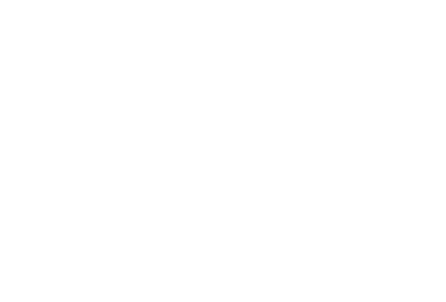

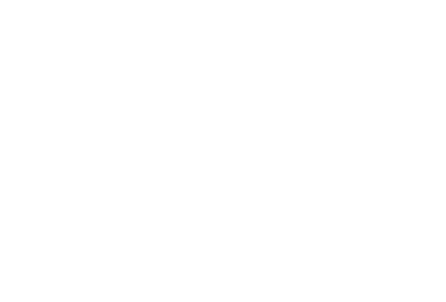

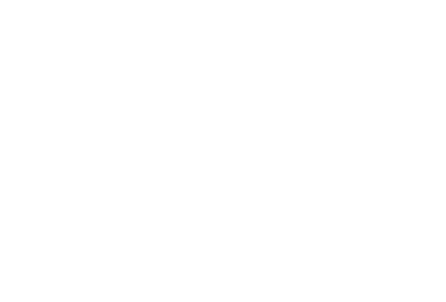

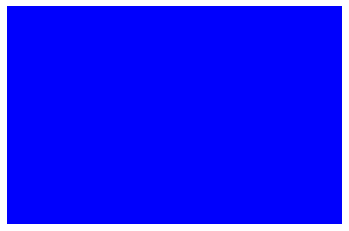

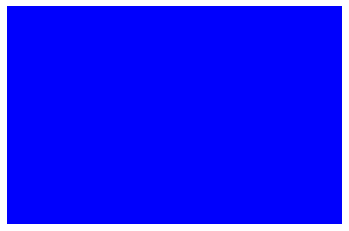

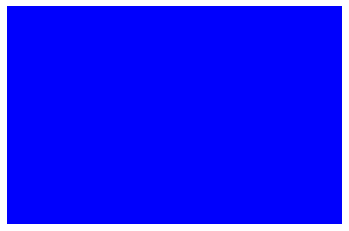

In [54]:
import warnings
warnings.filterwarnings('ignore')

exp = 'rot'
ax_val = 'all'
ss_val = 'all'
df_test2 = run_main_script(exp, ax_val, ss_val, df_timeseries_exp)

In [49]:
def run_main_script(exp, ax_val, ss_val, df_timeseries_exp):
    
    # ----------------
    
    df = get_df(ax_val, ss_val, df_timeseries_exp)

    feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0 = create_labels_and_initial_feature(df) 
    # Elasped time for feature processing :  715.9615476131439

    del df

    # ----------------

    if exists("df_feat.pkl") == False:
        print('Creation des marquers')
        df_feat = feature_creation_preprocessing(feat0, t_feat0)
        del feat0, t_feat0
        save_dat_pickle(df_feat, file_name="df_feat.pkl")
    else:
        print('Load des marquers')
        df_feat = load_dat_pickle(file_name="df_feat.pkl")
        
    df_org = df_feat
    
    del df_feat
    # ----------------

    col_list = ['num', 'pos', 'vel', 'acc', 'pos_nc', 'vel_nc', 'acc_nc', 'pos_sl0', 'pos_sl1', 'pos_sl2', 
                'pos_sl3', 'pos_sl4', 'vel_sl0', 'vel_sl1', 'vel_sl2', 'vel_sl3', 'vel_sl4', 'acc_sl0', 
                'acc_sl1', 'acc_sl2', 'acc_sl3', 'acc_sl4', 'pos_spec', 'vel_spec', 'acc_spec', 'pos_cwt', 
                'vel_cwt', 'acc_cwt', 'kmeans']
    df_org = pandas_rename_columns(df_org, col_list)
    df_org = df_org.reset_index(drop=True)  # reset index : delete the old index column
    # Gardez df_org
    
    # ----------------

    y_alllabel = [y1_feat0, y2_feat0, y3_feat0]
    
    # ----------------
    
    # Loop over the different y labels
    for ynum in range(1):    #range(len(y_alllabel)):
        print('ynum : ', ynum)
        
        # ----------------
        
        # Select y
        y_label = y_alllabel[ynum]
        
        # ----------------

        # Ajoutez le column de label à la fin
        y_pd = pd.Series(make_a_properlist(y_label))

        # ----------------

        df_feat = pd.concat([df_org, y_pd], axis=1)
        df_feat = df_feat.rename({0: 'y'}, axis=1)

        # ----------------

        # Balancez des class/labels: pad
        # Pad data 2 Make Classes Equivalent
        df_test2 = pad_data_2makeclasses_equivalent(df_feat)
        del df_feat
        
        # ----------------
        
        # classification for 3 partitions of feature data per 8 classifiers
        # classify(df_test2, ynum)
        
        # del df_test2

    return df_test2

In [ ]:
# Confirm AGAIN that the joystick signal is correct.
# Look at the joystick features
fig = make_subplots(rows=1, cols=1)

for i in range(len(feat0)):
    fig.append_trace(go.Scatter(x=t_feat0[i], y=feat0[i],), row=1, col=1)

fig.update_layout(height=600, width=600, title_text="Stacked Subplots")
fig.show()

# We check the signal for Classification because we create the position feature in 
# the function above by selecting the joystick movement on the axis in which there
# was the stimulus.

# Explination for why there is not a joystick signal in each field of feat0:
# In previous steps, we time-locked all "start and stop" indexing with the time
# vector in the experiment. 
# And we confirmed using the movement of the simulator cabin using the cabin 
# position and the joystick, using both cabin and joystick direction and amplitude.

# At the moment no good reason why the data is not correct - we dropped all avnormal 
# data in step B (s1_removeBADtrials_savedata)

# ----------------

In [ ]:
if os.path.exists("df_feat.pkl") == False:
    print('Creation des marquers')
    df_feat, rm_ind = feature_creation_preprocessing(feat0, t_feat0)
    del feat0, t_feat0
    save_dat_pickle(df_feat, file_name="df_feat.pkl")
    save_dat_pickle(rm_ind, file_name="rm_ind.pkl")
else:
    print('Load des marquers')
    df_feat = load_dat_pickle(file_name="df_feat.pkl")
    rm_ind = load_dat_pickle(file_name="rm_ind.pkl")

df_org = df_feat

del df_feat

In [ ]:
# ------------------------------
# Manual runs
# Justification for not doing a loop : Can not do a loop because the computer stops or it stops 
# for weird reasons.  Have to run each manually.
# ------------------------------


# -------------
# DONE
# -------------

exp = 'rot'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'all'
ss_val = 'sub'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'all'
ss_val = 'sup'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'trans'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'all'
ss_val = 'sub'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'all'
ss_val = 'sup'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'rot'
ax_val = 'ax0'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'ax1'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'ax2'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'trans'
ax_val = 'ax0'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'ax1'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'ax2'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)
